In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score


class CustomNeuralNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, activation_fn=nn.ReLU):
        super(CustomNeuralNet, self).__init__()
        layers = []

        prev_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(activation_fn())
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, output_size))  # Final output layer, no activation
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def run_nn_with_feature_selection(
    results, X_encoded, Y, file_name,
    k_features=10, epochs=100, lr=0.001,
    hidden_layers=[64, 128, 64], activation_fn=nn.ReLU,
    return_learning_curve=False
):

    # Split & scale
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Feature selection
    selector = SelectKBest(score_func=f_classif, k=k_features)
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)

    input_size = X_train.shape[1]
    num_classes = len(np.unique(Y))

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    # Build model
    model = CustomNeuralNet(input_size, num_classes, hidden_layers, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Track learning curve
    f1_scores = []

    for epoch in range(epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate F1 on test set per epoch
        model.eval()
        with torch.no_grad():
            pred_outputs = model(X_test_tensor)
            _, epoch_preds = torch.max(pred_outputs, 1)
            f1 = f1_score(y_test, epoch_preds.numpy(), average='micro')
            f1_scores.append(f1)

    # Final eval
    final_f1 = f1_scores[-1]
    cm = confusion_matrix(y_test, epoch_preds)
    print(f"NN F1 Score ({activation_fn.__name__}, layers {hidden_layers}):", final_f1)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {activation_fn.__name__}, layers {hidden_layers}')
    plt.savefig(f'Bankruptcy_Confusion_Matrix_{activation_fn.__name__}.png', bbox_inches='tight')

    plt.show()

    results[str((activation_fn.__name__, tuple(hidden_layers)))] = (final_f1, cm, model)

    if return_learning_curve:
        return f1_scores



def graph_nn_results(results_arr, file_name_base, results_names=None):
    plt.figure(figsize=(10, 5))

    i = 0
    for r_dict in results_arr:
        x_arr = []
        y_arr = []
        for k, v in r_dict.items():
            x_arr.append(k)
            y_arr.append(v[0])

        if results_names:
            plt.plot(x_arr, y_arr, marker='o', linestyle='-', linewidth=2, label=results_names[i])
            i += 1
        else:
            plt.plot(x_arr, y_arr, marker='o', linestyle='-', linewidth=2)

    plt.title('F1 Score vs K')
    plt.xlabel('Model')
    plt.ylabel('F1 Score Score')

    #if results_names:
        #plt.legend()

    plt.tight_layout()
    plt.savefig(file_name_base, bbox_inches='tight')
    plt.show()

def plot_learning_curve(f1_scores, title="Learning Curve", save_path=None):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score (Weighted)")
    plt.title(title)
    plt.grid(True)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


NN F1 Score (ReLU, layers [128, 128, 128]): 0.9640762463343109


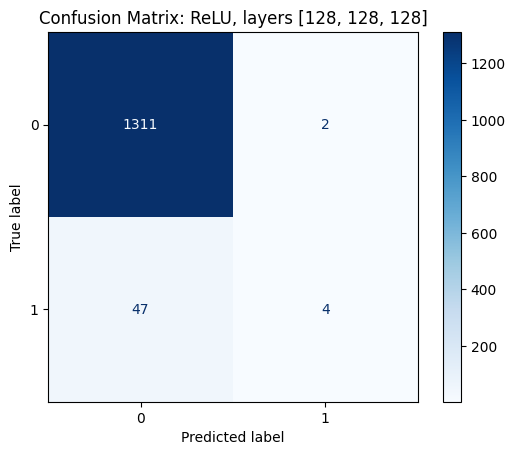

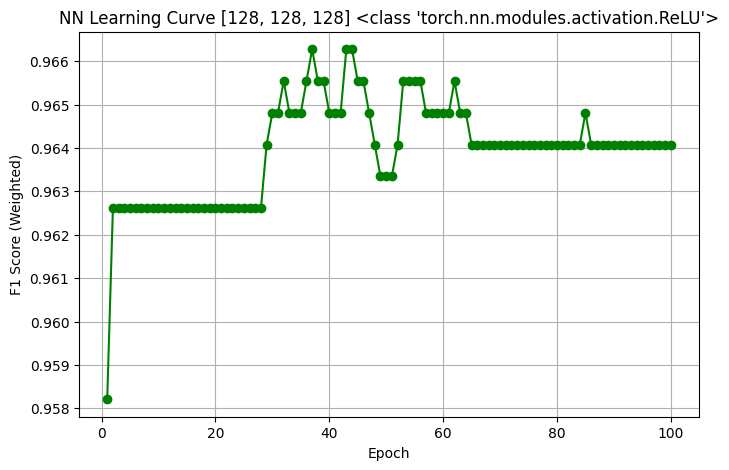

NN F1 Score (ReLU, layers [128, 64, 32, 16, 8]): 0.9633431085043989


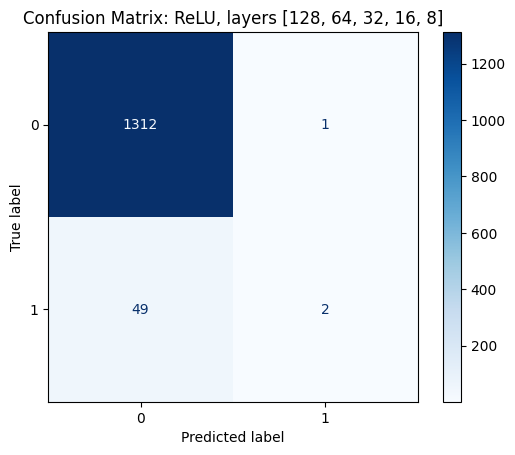

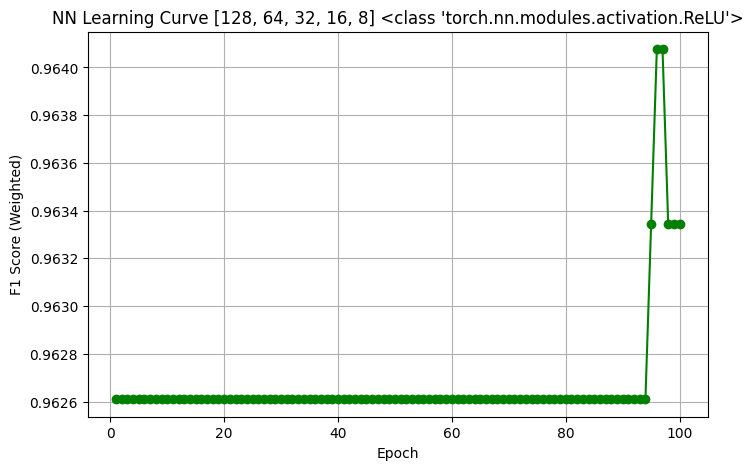

NN F1 Score (Tanh, layers [128, 128, 128]): 0.9648093841642229


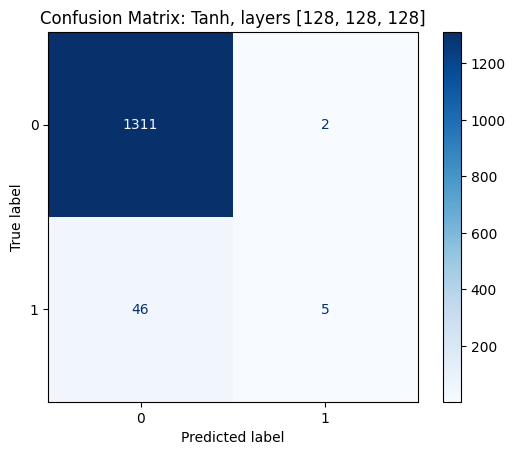

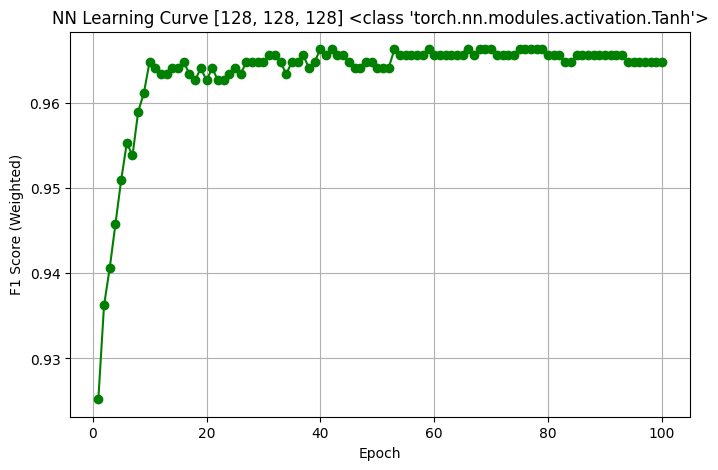

NN F1 Score (LeakyReLU, layers [128, 128, 128]): 0.9648093841642229


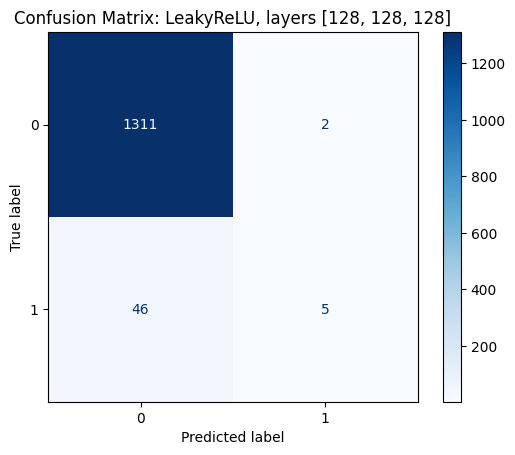

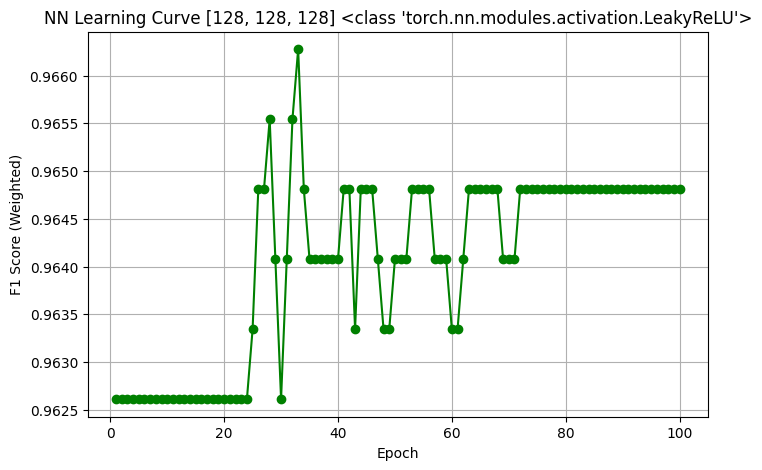

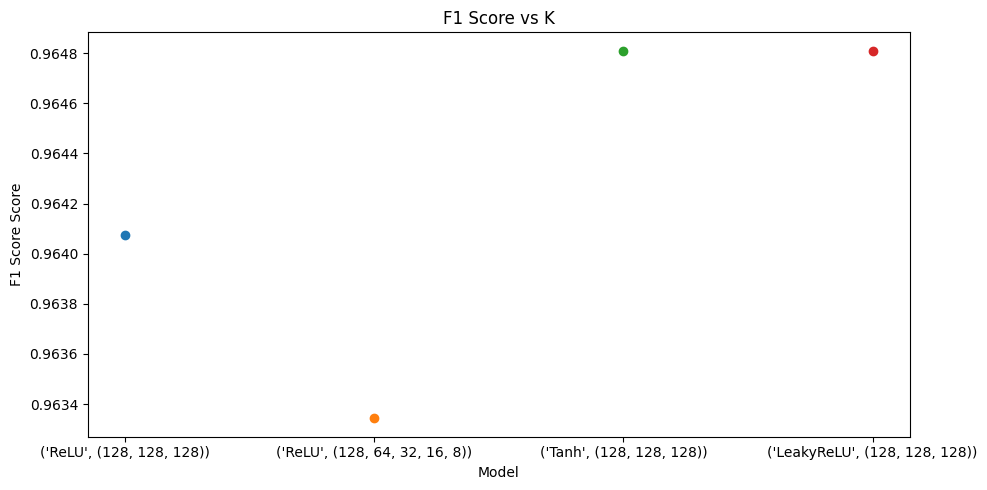

In [3]:
import pandas as pd

# Load CSV
df = pd.read_csv('bankruptcy_data.csv')

X = df.drop(['Bankrupt?', ' Net Income Flag', ' Liability-Assets Flag'], axis=1)
Y = df['Bankrupt?']



configs = [
    ([128, 128, 128], nn.ReLU),
    ([128, 64, 32, 16, 8], nn.ReLU),
    ([128, 128, 128], nn.Tanh),
    ([128, 128, 128], nn.LeakyReLU),
]

all_results = []
for hidden_layers, act_fn in configs:
    result = {}
    learning_curve  = run_nn_with_feature_selection(result, X, Y, "bankrupt_nn_", hidden_layers=hidden_layers, activation_fn=act_fn, return_learning_curve = True)
    all_results.append(result)
    plot_learning_curve(learning_curve, title="NN Learning Curve " + str(hidden_layers) + " " + str(act_fn), save_path=f"bankruptcy_nn_{act_fn.__name__}")

graph_nn_results(all_results, "bankrupt_nn_comparison", results_names=[str(c) for c in configs])

